In [1]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchsparse
import laspy

from EHydro_TreeUnet.tree_projector import TreeProjector
from EHydro_TreeUnet.tree_unet import UNet
from pathlib import Path

from torch import nn
from torch.nn import functional as tF
from torch.cuda import amp
from torchsparse import SparseTensor
from torchsparse.nn import functional as F
from torch.utils.data import random_split, DataLoader
from torchsparse.utils.collate import sparse_collate_fn
from torchsparse.utils.quantize import sparse_quantize
from scipy.optimize import linear_sum_assignment

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
TRAINING = True

CHANNELS = [64, 128, 256]
LATENT_DIM = 512
MAX_INSTANCES = 64
TRAIN_PCT = 0.8
VOXEL_SIZE = 0.2
DATA_AUGMENTATION_COEF = 1.0
SEMANTIC_LOSS_COEF = 1.0
INSTANCE_LOSS_COEF = 0.0
BATCH_SIZE = 1

In [ ]:
class FORinstanceDataset:
    def __init__(self, voxel_size: float, data_augmentation: float = 1.0, yaw_range = (0, 360), tilt_range = (-5, 5), scale = (0.9, 1.1)) -> None:
        self._rng = np.random.default_rng()
        self._folder = Path('./datasets/MixedDataset')
        self._extensions = ('.laz', '.las')
        self._feat_channels = 1
        self._num_classes = 3
        self._class_names = ['Terrain', 'Stem', 'Live-branches']
        self._class_labels = np.array([1, 4, 5])  # IDs en el dataset original. Se remapean a [0, 1, 2]
        self._class_colormap = np.array([
            [128, 128, 128],# clase 0 - Terrain - gris
            [255, 165, 0],  # clase 1 - Stem - naranja
            [0, 128, 0],    # clase 2 - Live-branches - verde oscuro
        ], dtype=np.uint8)
        
        self._files = sorted(
            [f for f in self._folder.rglob("*") if f.is_file() and f.suffix.lower() in self._extensions],
            key=lambda f: f.name
        )

        self._voxel_size = voxel_size
        self._len = int(len(self._files) * data_augmentation)
        
        self._yaw_range = yaw_range
        self._tilt_range = tilt_range
        self._scale = scale
        
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return [self._preprocess(self.files[i]) for i in range(*idx.indices(len(self)))]
        elif isinstance(idx, int):
            if idx < 0:
                idx += len(self)
            if idx < 0 or idx >= len(self):
                raise IndexError("Index out of range")
            return self._preprocess(idx)
        else:
            raise TypeError("Index must be a slice or an integer")
        
    def __len__(self):
        return self._len
    
    @property
    def feat_channels(self):
        return self._feat_channels
    
    @property
    def num_classes(self):
        return self._num_classes

    @property
    def class_names(self):
        return self._class_names
    
    @property
    def class_colormap(self):
        return self._class_colormap
    
    def _load_file(self, path):
        ext = path.suffix.lower()

        coords = ...
        feats = ...
        semantic_labels = ...
        
        if ext in ('.las, .laz'):
            file = laspy.read(path)

            coords = np.vstack((file.x, file.y, file.z)).transpose()
            coords -= np.min(coords, axis=0, keepdims=True)
            # feats = np.hstack((np.array(file.intensity)[:, None], coords))
            feats = np.array(file.intensity)[:, None] / 65535
            semantic_labels = np.array(file.classification)
            instance_labels = np.array(file.treeID)
        else:
            raise ValueError(f'Unsopported file extension: {ext}!')

        return coords, feats, semantic_labels, instance_labels
    
    def _agument_data(self, coords):
        yaw = np.deg2rad(self._rng.uniform(*self._yaw_range))
        pitch = np.deg2rad(self._rng.uniform(*self._tilt_range))
        roll = np.deg2rad(self._rng.uniform(*self._tilt_range))
        scale = self._rng.uniform(*self._scale)

        cy, sy = np.cos(yaw), np.sin(yaw)
        cp, sp = np.cos(pitch), np.sin(pitch)
        cr, sr = np.cos(roll), np.sin(roll)

        rotation_mtx = np.array([[cy*cp,  cy*sp*sr - sy*cr,  cy*sp*cr + sy*sr],
                                 [sy*cp,  sy*sp*sr + cy*cr,  sy*sp*cr - cy*sr],
                                 [ -sp ,            cp*sr ,            cp*cr ]],
                                dtype=coords.dtype)

        return (coords @ rotation_mtx.T) * scale
        
    def _preprocess(self, idx: int):
        coords, feat, semantic_labels, instance_labels = self._load_file(self._files[idx % len(self._files)])
        if idx >= len(self._files):
            coords = self._agument_data(coords)

        voxels, indices, inverse_map = sparse_quantize(coords, self._voxel_size, return_index=True, return_inverse=True)
        feat = feat[indices]
        semantic_labels = semantic_labels[indices]
        instance_labels = instance_labels[indices]

        voxels = torch.tensor(voxels, dtype=torch.int)
        feat = torch.tensor(feat.astype(np.float32), dtype=torch.float)
        semantic_labels = torch.tensor(semantic_labels, dtype=torch.long)
        instance_labels = torch.tensor(instance_labels, dtype=torch.long)

        inputs = SparseTensor(coords=voxels, feats=feat)
        semantic_labels = SparseTensor(coords=voxels, feats=semantic_labels)
        instance_labels = SparseTensor(coords=voxels, feats=instance_labels)

        return {"inputs": inputs, "semantic_labels": semantic_labels, "instance_labels": instance_labels, "coords": coords, "inverse_map": inverse_map}

In [ ]:
class TreeProjectorTrainer:
    def __init__(self):
        conv_config = F.conv_config.get_default_conv_config(conv_mode=F.get_conv_mode())
        conv_config.kmap_mode = 'hashmap'
        F.conv_config.set_global_conv_config(conv_config)

        self._dataset = FORinstanceDataset(voxel_size=VOXEL_SIZE, data_augmentation=DATA_AUGMENTATION_COEF)
        train_size = int(TRAIN_PCT * len(self._dataset))
        val_size = len(self._dataset) - train_size

        self._model = TreeProjector(self._dataset.feat_channels, self._dataset.num_classes, MAX_INSTANCES, channels = CHANNELS, latent_dim = LATENT_DIM)
        # self._model = UNet(self._dataset.feat_channels, self._dataset.num_classes, base_channels=64, depth=3)
        self._device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        total_params = sum(p.numel() for p in self._model.parameters())
        trainable_params = sum(p.numel() for p in self._model.parameters() if p.requires_grad)

        print(f"Parámetros totales: {total_params:,}")
        print(f"Parámetros entrenables: {trainable_params:,}")
        
        train_dataset, val_dataset = random_split(self._dataset, [train_size, val_size])

        self._train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=sparse_collate_fn)
        self._val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=sparse_collate_fn)

        self._criterion_semantic = nn.CrossEntropyLoss()
        self._criterion_instance = nn.CrossEntropyLoss()

        if not TRAINING:
            self._load_weights()

        self._model.to(self._device)

    @property
    def dataset(self):
        return self._dataset

    def _load_weights(self):
        self._model.load_state_dict(torch.load('./weights/tree_unet_weights.pth'))

    @torch.no_grad()
    def _apply_hungarian(self, logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        N, K = logits.shape
        device = logits.device

        log_p = tF.log_softmax(logits, dim=-1)

        uniq = torch.unique(labels)
        M    = len(uniq)

        cost = torch.empty((M, K), device=device)
        for m, g in enumerate(uniq):
            mask = (labels == g)
            cost[m] = -(log_p[mask].mean(0))

        row, col = linear_sum_assignment(cost.detach().cpu())

        remapped = torch.full_like(labels, fill_value=-1)
        for r, c in zip(row, col):
            g = uniq[r]
            remapped[labels == g] = c

        return remapped

    def _compute_loss(self, semantic_output, semantic_labels, instance_output, instance_labels):
        loss_sem = self._criterion_semantic(semantic_output, semantic_labels)
        loss_inst = self._criterion_instance(instance_output, self._apply_hungarian(instance_output, instance_labels))

        return SEMANTIC_LOSS_COEF * loss_sem + INSTANCE_LOSS_COEF * loss_inst
    
    def _compute_iou(self, semantic_output, semantic_labels):
        if semantic_output.C.shape != semantic_labels.C.shape or not torch.all(semantic_output.C == semantic_labels.C):
            raise ValueError("Dimensions doesn't match between semantic labels and output.")

        semantic_output = semantic_output.F.argmax(dim=1)
        semantic_labels = semantic_labels.F.view(-1).long()
        iou_list = torch.full((self._dataset.num_classes,), float('nan'), device=semantic_output.device)

        for cls in range(self._dataset.num_classes):
            label_mask = semantic_labels == cls
            out_mask = semantic_output == cls

            union = (out_mask | label_mask).sum()
            if union == 0:
                continue

            inter = (out_mask & label_mask).sum()
            iou_list[cls] = inter.float() / union.float()

        valid = ~torch.isnan(iou_list)
        miou  = iou_list[valid].mean().item() if valid.any() else float("nan")
        return iou_list, miou
            
    def _gen_charts(self, losses, iou_list, miou, training):
        plt.figure(figsize=(10, 5))
        plt.plot(losses, label=f"{'Training' if training else 'Inference'} Loss")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.title(f"Loss evolution during {'Training' if training else 'Inference'}")
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(miou, label=f"{'Training' if training else 'Inference'} mIoU")
        plt.xlabel("Step")
        plt.ylabel("mIoU")
        plt.title(f"mIoU evolution during {'Training' if training else 'Inference'}")
        plt.legend()
        plt.grid(True)
        plt.show()

        iou_arr = np.asarray(iou_list)
        plt.figure(figsize=(10, 5))
        for c in range(self._dataset.num_classes):
            plt.plot(iou_arr[:, c], label=self._dataset.class_names[c])
        
        plt.xlabel("Step")
        plt.ylabel("IoU")
        plt.title(f"IoU evolution during {'Training' if training else 'Inference'}")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def train(self):
        optimizer = torch.optim.Adam(self._model.parameters(), lr=1e-3)
        scaler = amp.GradScaler(enabled=True)
        losses = []
        iou_list = []
        miou = []

        for k, feed_dict in enumerate(self._train_loader):
            inputs = feed_dict["inputs"].to(self._device)
            semantic_labels = feed_dict["semantic_labels"].to(self._device)
            instance_labels = feed_dict["instance_labels"].to(self._device)

            with amp.autocast(enabled=True):
                semantic_output, instance_output = self._model(inputs)
                loss = self._compute_loss(semantic_output.F, semantic_labels.F, instance_output.F, instance_labels.F)
                step_iou, step_miou = self._compute_iou(semantic_output, semantic_labels)
                iou_list.append(step_iou.cpu().numpy())
                miou.append(step_miou)

            print(f"[Train step {k + 1}] loss = {loss.item()}; mIoU = {step_miou}")
            losses.append(loss.item())

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        torch.save(self._model.state_dict(), './weights/tree_unet_weights.pth')
        self._gen_charts(losses, iou_list, miou, True)

    def eval(self):
        self._model.eval()
        losses = []
        iou_list = []
        miou = []

        # enable torchsparse 2.0 inference
        # enable fused and locality-aware memory access optimization
        torchsparse.backends.benchmark = True  # type: ignore

        with torch.no_grad():
            for k, feed_dict in enumerate(self._val_loader):
                semantic_labels_cpu = feed_dict["semantic_labels"].F.numpy()
                instance_labels_cpu = feed_dict["instance_labels"].F.numpy()
                coords = feed_dict["coords"].numpy()
                inverse_map = feed_dict["inverse_map"].numpy()

                inputs = feed_dict["inputs"].to(self._device)
                semantic_labels = feed_dict["semantic_labels"].to(self._device)
                instance_labels = feed_dict["instance_labels"].to(self._device)

                with amp.autocast(enabled=True):
                    semantic_output, instance_output = self._model(inputs)
                    loss = self._compute_loss(semantic_output.F, semantic_labels.F, instance_output.F, instance_labels.F)
                    step_iou, step_miou = self._compute_iou(semantic_output, semantic_labels)
                    iou_list.append(step_iou.cpu().numpy())
                    miou.append(step_miou)

                print(f"[Inference step {k + 1}] loss = {loss.item()}; mIoU = {step_miou}")
                losses.append(loss.item())

                voxels = semantic_output.C[:, 1:].cpu().numpy()
                semantic_output = torch.argmax(semantic_output.F.cpu(), dim=1).numpy()
                instance_output = torch.argmax(instance_output.F.cpu(), dim=1).numpy()

                yield voxels, semantic_output, instance_output, semantic_labels_cpu, instance_labels_cpu, coords, inverse_map

        self._gen_charts(losses, iou_list, miou, False)

        print(f'Loss medio: {sum(losses) / len(losses)}')
        print(f'mIoU medio: {sum(miou) / len(miou)}')

In [5]:
'''
tester = TreeProjectorTrainer()

torch.manual_seed(0)

N, K = 12, 3                       # 12 puntos, 3 canales (max_inst)
semantic_lbl = torch.randint(0, 4, (N,))

# Instancias GT: bloques de 4 puntos
inst_lbl = torch.tensor([0]*4 + [1]*4 + [2]*4)

# Logits: cada instancia favorece un canal *distinto*
inst_out = torch.randn(N, K) * 0.3
inst_out[:4, 1] += 3.0   # inst-0 -> canal-1
inst_out[4:8, 2] += 3.0  # inst-1 -> canal-2
inst_out[8:, 0]  += 3.0  # inst-2 -> canal-0

# Pérdida con labels originales (mala correspondencia)
loss_bad = tester._criterion_instance(inst_out, inst_lbl)

# Pérdida tras húngaro + remapeo
remap = tester._apply_hungarian(inst_out, inst_lbl)
print(remap)
loss_good = tester._criterion_instance(inst_out, remap)

print(f"Loss antes  = {loss_bad.item():.3f}")
print(f"Loss después = {loss_good.item():.3f}")

print(inst_out)
print(inst_lbl)
print(remap)
'''

'\ntester = TreeProjectorTrainer()\n\ntorch.manual_seed(0)\n\nN, K = 12, 3                       # 12 puntos, 3 canales (max_inst)\nsemantic_lbl = torch.randint(0, 4, (N,))\n\n# Instancias GT: bloques de 4 puntos\ninst_lbl = torch.tensor([0]*4 + [1]*4 + [2]*4)\n\n# Logits: cada instancia favorece un canal *distinto*\ninst_out = torch.randn(N, K) * 0.3\ninst_out[:4, 1] += 3.0   # inst-0 -> canal-1\ninst_out[4:8, 2] += 3.0  # inst-1 -> canal-2\ninst_out[8:, 0]  += 3.0  # inst-2 -> canal-0\n\n# Pérdida con labels originales (mala correspondencia)\nloss_bad = tester._criterion_instance(inst_out, inst_lbl)\n\n# Pérdida tras húngaro + remapeo\nremap = tester._apply_hungarian(inst_out, inst_lbl)\nprint(remap)\nloss_good = tester._criterion_instance(inst_out, remap)\n\nprint(f"Loss antes  = {loss_bad.item():.3f}")\nprint(f"Loss después = {loss_good.item():.3f}")\n\nprint(inst_out)\nprint(inst_lbl)\nprint(remap)\n'

Parámetros totales: 20,721,088
Parámetros entrenables: 20,721,088
[Train step 1] loss = 1.2958859205245972; mIoU = 0.09123009443283081
[Train step 2] loss = 1.3745646476745605; mIoU = 0.37075018882751465
[Train step 3] loss = 0.85008305311203; mIoU = 0.48073717951774597
[Train step 4] loss = 0.5553855299949646; mIoU = 0.47780653834342957
[Train step 5] loss = 0.509255051612854; mIoU = 0.538923978805542
[Train step 6] loss = 0.4997572898864746; mIoU = 0.46609926223754883
[Train step 7] loss = 0.48658299446105957; mIoU = 0.5331258773803711
[Train step 8] loss = 0.5473741292953491; mIoU = 0.4736616015434265
[Train step 9] loss = 0.45027580857276917; mIoU = 0.5640164613723755
[Train step 10] loss = 0.4374547600746155; mIoU = 0.5519381761550903
[Train step 11] loss = 1.9984591007232666; mIoU = 0.30005478858947754
[Train step 12] loss = 0.9855685234069824; mIoU = 0.36961302161216736
[Train step 13] loss = 0.3308846950531006; mIoU = 0.6165041923522949
[Train step 14] loss = 0.3736924231052398

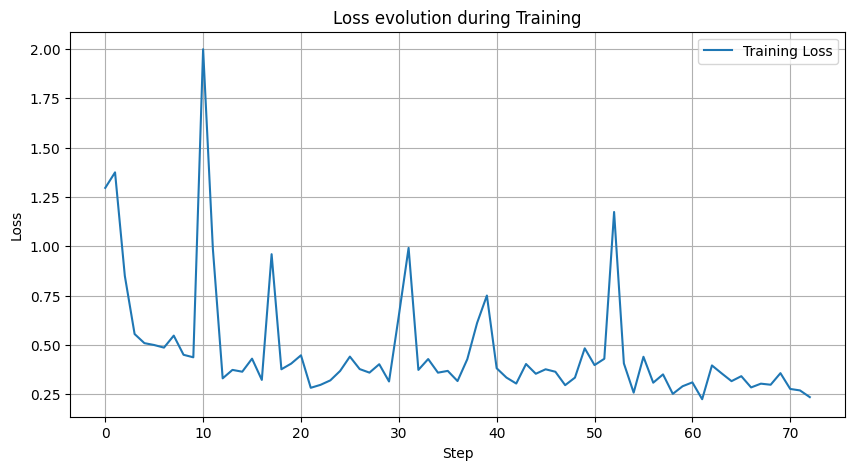

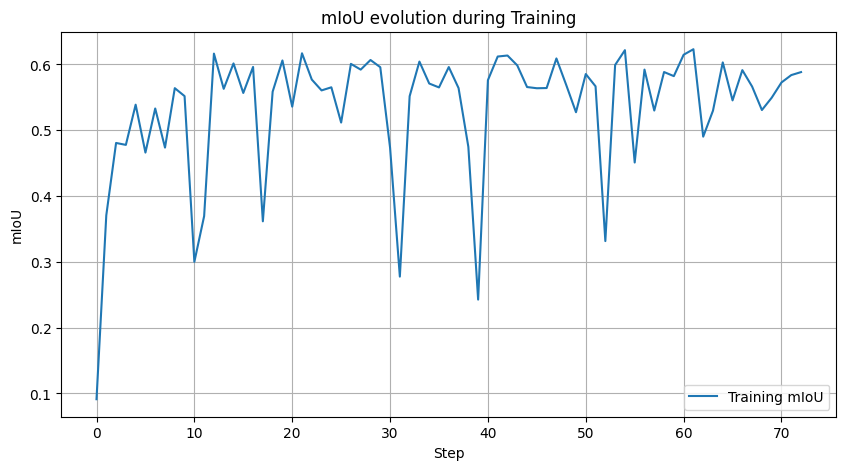

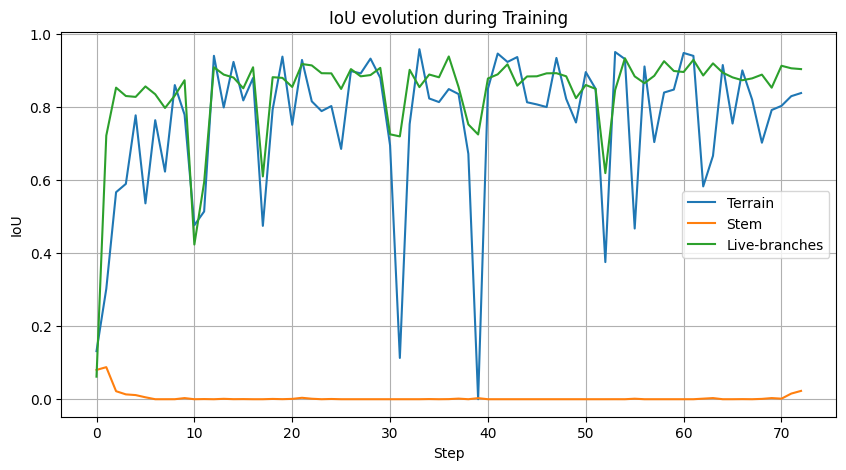

[Inference step 1] loss = 0.2850484251976013; mIoU = 0.5543593168258667
[Inference step 2] loss = 0.23741190135478973; mIoU = 0.6281765699386597
[Inference step 3] loss = 0.2668972611427307; mIoU = 0.5823935270309448
[Inference step 4] loss = 0.33513662219047546; mIoU = 0.6161243915557861
[Inference step 5] loss = 0.3669373393058777; mIoU = 0.6132756471633911
[Inference step 6] loss = 0.37760812044143677; mIoU = 0.5122029781341553
[Inference step 7] loss = 0.24642574787139893; mIoU = 0.30770325660705566
[Inference step 8] loss = 0.34824076294898987; mIoU = 0.637840986251831
[Inference step 9] loss = 0.3836306631565094; mIoU = 0.6131923198699951
[Inference step 10] loss = 0.28872910141944885; mIoU = 0.6178990602493286
[Inference step 11] loss = 0.3811853229999542; mIoU = 0.5767669677734375
[Inference step 12] loss = 0.26792439818382263; mIoU = 0.5972754955291748
[Inference step 13] loss = 0.3377901315689087; mIoU = 0.5879971385002136
[Inference step 14] loss = 0.3313955068588257; mIoU =

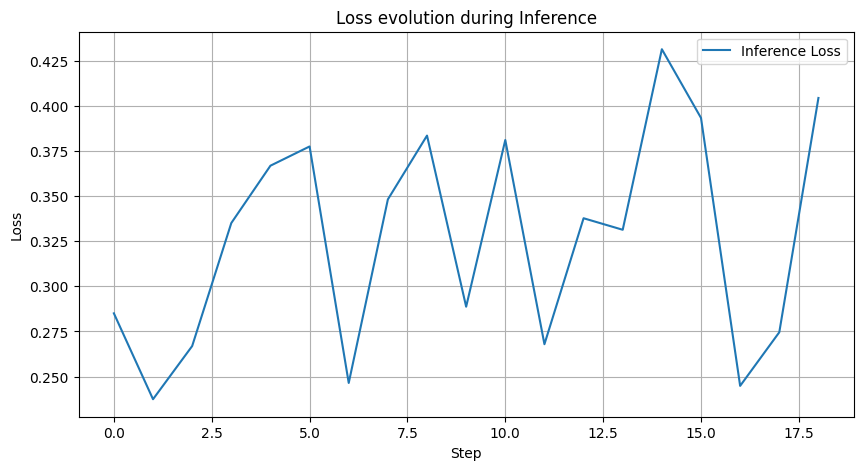

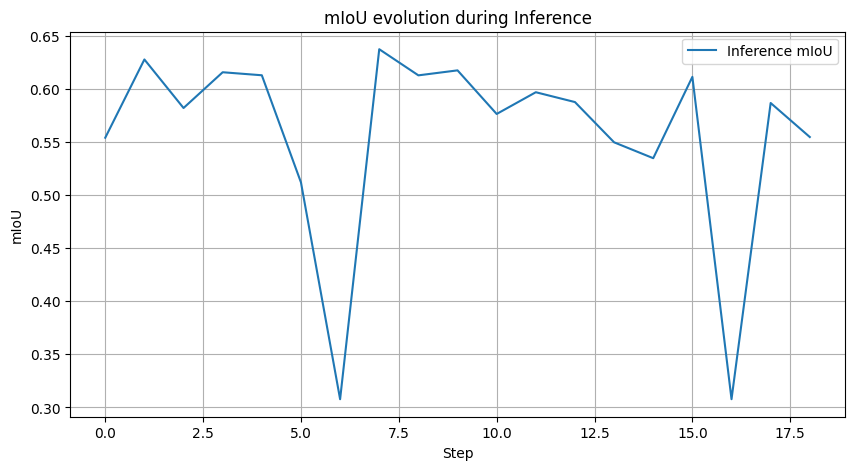

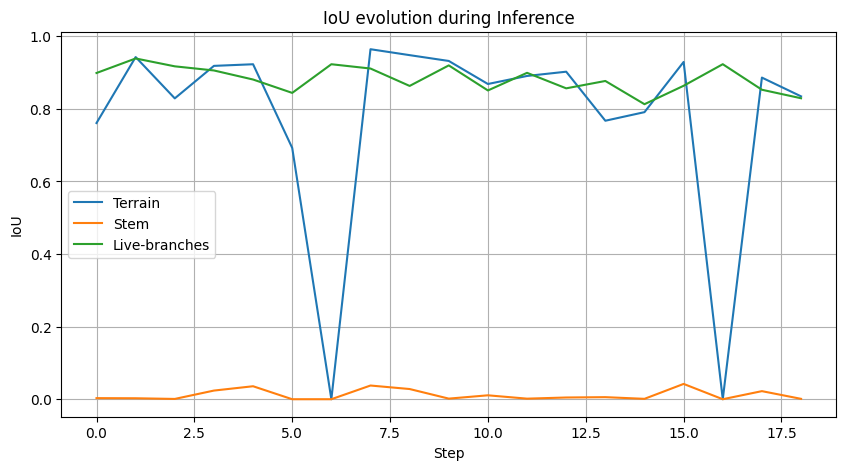

Loss medio: 0.326483973547032
mIoU medio: 0.5574704377274764


In [6]:
tester = TreeProjectorTrainer()

if TRAINING:
    tester.train()

pcd = o3d.geometry.PointCloud()
for voxels, semantic_output, instance_output, semantic_labels, instance_labels, coords, inverse_map in tester.eval():
    continue
    coords = coords[0]
    inverse_map = inverse_map[0]

    colors = tester.dataset.class_colormap[semantic_labels[inverse_map]] / 255.0

    pcd.points = o3d.utility.Vector3dVector(coords)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd])

    colors = tester.dataset.class_colormap[semantic_output[inverse_map]] / 255.0
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd])

    unique_ids = np.unique(instance_labels)
    rng = np.random.default_rng(0)
    palette = rng.random((len(unique_ids), 3))

    id2color = {uid: palette[i] for i, uid in enumerate(unique_ids)}
    colors = np.array([id2color[i] for i in instance_labels], dtype=np.float64)

    pcd.points = o3d.utility.Vector3dVector(coords)
    pcd.colors = o3d.utility.Vector3dVector(colors[inverse_map])
    o3d.visualization.draw_geometries([pcd])

    unique_ids = np.unique(instance_output)
    rng = np.random.default_rng(0)
    palette = rng.random((len(unique_ids), 3))

    id2color = {uid: palette[i] for i, uid in enumerate(unique_ids)}
    colors = np.array([id2color[i] for i in instance_output], dtype=np.float64)

    pcd.points = o3d.utility.Vector3dVector(coords)
    pcd.colors = o3d.utility.Vector3dVector(colors[inverse_map])
    o3d.visualization.draw_geometries([pcd])

